In [1]:
import numpy as np
import emoji
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kl_div
from nltk.sentiment import SentimentIntensityAnalyzer
from data import source_wsl, output
from util import text, null
from util import Pipeline
from concurrent.futures import ProcessPoolExecutor


sia = SentimentIntensityAnalyzer()

def token_to_sentiment(row):
    text_ = " ".join(row)
    return pd.Series(sia.polarity_scores(text_))


In [2]:
data = pd.read_csv(source_wsl)
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
text_preprocess = {
	'replace emoji': [text.replace_emoji, null],
	'remove retweet symbol': [text.remove_retweet],
	'remove url': [(text.remove_pattern, text.PATTERN['url'])],
	'remove punctuation': [(text.remove_pattern, text.PATTERN['slight punc']), null, (text.remove_pattern, text.PATTERN['punc'])],  # ATTENTION: it will remove @ #
	'to lower': [str.lower, null],
	'remove _': [(text.replace_pattern, r'_', ' ')],
	'tokenize': [nltk.tokenize.word_tokenize],
	'lemmatize': [text.lemmatize, null],
	'remove stopwords': [(text.remove_stopwords, text.STOP_WORDS + ['amp'])],
}  # input original text

pipelines = Pipeline.from_config(text_preprocess)

In [4]:
def process(tweets: pd.Series, pipeline):
	return pd.Series([pipeline(tweet) for tweet in tweets.to_numpy()])
		
pool = ProcessPoolExecutor()		
tweets = data['tweet']
futures = [pool.submit(process, tweets, pipeline) for pipeline in pipelines]
processed_texts = [pd.Series(future.result()) for future in futures]
# processed_texts = [future.result() for future in futures]
pool.shutdown()

In [5]:
processed_texts[0]

0        [!, !, !, mayasolovely, woman, n't, complain, ...
1        [!, !, !, !, !, mleew17, boy, coldtyga, dwn, c...
2        [!, !, !, !, !, !, !, urkindofbrand, dawg, !, ...
3        [!, !, !, !, !, !, !, !, !, g, anderson, viva,...
4        [!, !, !, !, !, !, !, !, !, !, !, !, !, shenik...
                               ...                        
24778    ['s, muthafin, lie, lifeasking, 20, pearl, cor...
24779    ['ve, broke, wrong, heart, baby, drove, rednec...
24780    [young, buck, wan, eat, !, !, nigguh, fuckin, ...
24781                     [youu, wild, bitch, tellin, lie]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

In [6]:
sentiment_scores = [texts.apply(token_to_sentiment) for texts in processed_texts]

In [7]:
sentiment_scores[0]

,neg,neu,pos,compound
0,0.000,0.668,0.332,0.4563
1,0.000,1.000,0.000,0.0000
2,0.814,0.186,0.000,-0.9550
3,0.000,1.000,0.000,0.0000
4,0.682,0.318,0.000,-0.8614
...,...,...,...,...
24778,0.000,1.000,0.000,0.0000
24779,0.624,0.376,0.000,-0.8074
24780,0.000,1.000,0.000,0.0000
24781,0.487,0.513,0.000,-0.5859


In [8]:
polar = data['class'].map({2: -1, 1: -1, 0: 1})
polar

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
24778   -1
24779   -1
24780   -1
24781   -1
24782   -1
Name: class, Length: 24783, dtype: int64

In [9]:
kl_div(polar+2, sentiment_scores[0]['compound']+2).mean(), kl_div(polar+2, sentiment_scores[1]['compound']+2).mean()

(0.2562251320912583, 0.24319356907663586)

In [10]:
kl = [kl_div(polar+2, sentiment_score['compound']+2).mean() for sentiment_score in sentiment_scores]
kl

[0.2562251320912583,
 0.24319356907663586,
 0.2559506717562535,
 0.24335733119417302,
 0.25599556050788785,
 0.24297274775417357,
 0.2556591533593347,
 0.24312840577808123,
 0.24601616731121673,
 0.23235004828186256,
 0.2458092165932067,
 0.2326235868789982,
 0.23153067477510195,
 0.22516347039204979,
 0.23128470935999002,
 0.22534475520230624,
 0.23069014499956472,
 0.2243182494339855,
 0.23038451918199998,
 0.2245010694336899,
 0.22044052640161224,
 0.2140218213818579,
 0.22029955150340466,
 0.21432034140846215]

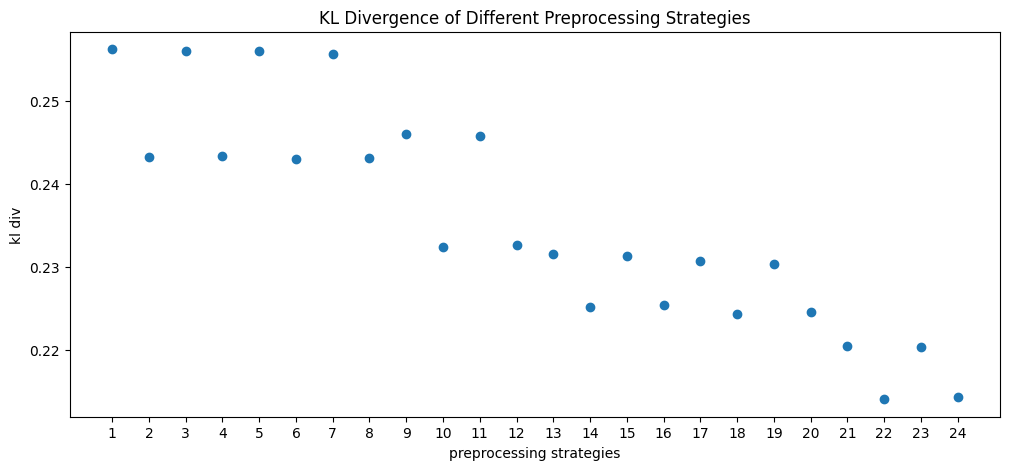

In [11]:
title = "KL Divergence of Different Preprocessing Strategies"
plt.figure(figsize=(12, 5))
plt.title(title)
plt.ylabel("kl div")
plt.xlabel("preprocessing strategies")
plt.xticks(ticks=range(len(kl)), labels=range(1, 1+len(kl)))
plt.scatter(range(len(kl)), kl)
plt.savefig(output + f'/img/{title}.svg')

In [12]:
text.PATTERN['punc']

'[^\\w\\s]'

In [14]:
from util import text
text.STOP_WORDS.remove('not')

# 结论

使用全策略
（要删除标点，但标点在该场景下的确携带丰富信息--单独抽取特征）
（要替换emoji，emoji对于kl散度有一定的提升）